<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/Deep_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 06: Very Deep CNN
## Objective: Explore the impact of network depth on performance and training dynamics

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 95% 270M/285M [00:00<00:00, 592MB/s]
100% 285M/285M [00:00<00:00, 632MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [6]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp06-very-deep-cnn",
    config={
        "architecture": "Very Deep CNN (VGG-19 style)",
        "dataset": "FER2013",
        "epochs": 30,
        "batch_size": 32,  # Smaller batch size for deeper model
        "learning_rate": 0.0001,  # Lower learning rate for stability
        "weight_decay": 0.0001,
        "dropout_conv": 0.2,
        "dropout_fc": 0.5,
        "batch_norm": True,
        "conv_blocks": 6,
        "conv_channels": [64, 128, 256, 512, 512, 512],
        "fc_sizes": [4096, 2048, 1024],
        "num_classes": 7
    }
)
# api key 380014f2a984b49876832184c6bd2dcddb337047

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


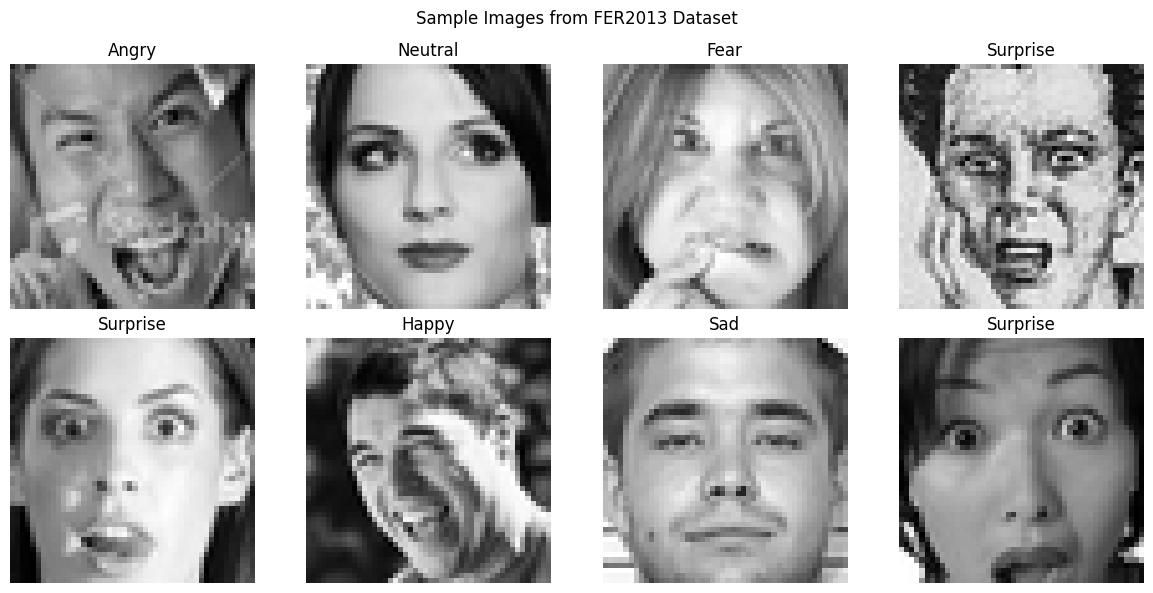

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [9]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [10]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders with smaller batch size for deeper model
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [11]:
# Very Deep CNN Model (VGG-19 inspired)
class VeryDeepCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_conv=0.2, dropout_fc=0.5):
        super(VeryDeepCNN, self).__init__()

        # Block 1: 64 channels
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_conv)

        # Block 2: 128 channels
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_conv)

        # Block 3: 256 channels
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_3 = nn.BatchNorm2d(256)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_conv)

        # Block 4: 512 channels
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_3 = nn.BatchNorm2d(512)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(dropout_conv)

        # Block 5: 512 channels (deeper)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_4 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout2d(dropout_conv)

        # Block 6: 512 channels (even deeper)
        self.conv6_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6_1 = nn.BatchNorm2d(512)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(512)
        self.dropout6 = nn.Dropout2d(dropout_conv)

        # Adaptive pooling to handle any input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers (very large)
        self.fc1 = nn.Linear(512, 4096)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        self.dropout_fc1 = nn.Dropout(dropout_fc)

        self.fc2 = nn.Linear(4096, 2048)
        self.bn_fc2 = nn.BatchNorm1d(2048)
        self.dropout_fc2 = nn.Dropout(dropout_fc)

        self.fc3 = nn.Linear(2048, 1024)
        self.bn_fc3 = nn.BatchNorm1d(1024)
        self.dropout_fc3 = nn.Dropout(dropout_fc)

        self.fc4 = nn.Linear(1024, num_classes)

        # Activation
        self.relu = nn.ReLU(inplace=True)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.relu(self.bn2_1(self.conv2_1(x)))
        x = self.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.relu(self.bn3_3(self.conv3_3(x)))
        x = self.relu(self.bn3_4(self.conv3_4(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = self.relu(self.bn4_1(self.conv4_1(x)))
        x = self.relu(self.bn4_2(self.conv4_2(x)))
        x = self.relu(self.bn4_3(self.conv4_3(x)))
        x = self.relu(self.bn4_4(self.conv4_4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Block 5
        x = self.relu(self.bn5_1(self.conv5_1(x)))
        x = self.relu(self.bn5_2(self.conv5_2(x)))
        x = self.relu(self.bn5_3(self.conv5_3(x)))
        x = self.relu(self.bn5_4(self.conv5_4(x)))
        x = self.pool5(x)
        x = self.dropout5(x)

        # Block 6
        x = self.relu(self.bn6_1(self.conv6_1(x)))
        x = self.relu(self.bn6_2(self.conv6_2(x)))
        x = self.dropout6(x)

        # Adaptive pooling and flatten
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)

        x = self.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout_fc3(x)

        x = self.fc4(x)

        return x

In [12]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VeryDeepCNN().to(device)
print(f"Total parameters: {model.total_params:,}")

criterion = nn.CrossEntropyLoss()
# Lower learning rate for deeper model stability
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Learning rate scheduler for deep networks
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Log model architecture to W&B
wandb.watch(model, log='all')

Using device: cuda
Total parameters: 37,367,495


In [13]:
# Print model architecture summary
print("Model Architecture Summary:")
print("=" * 50)
print("Convolutional Blocks:")
print("  Block 1: 1 -> 64 -> 64 (2 conv layers)")
print("  Block 2: 64 -> 128 -> 128 (2 conv layers)")
print("  Block 3: 128 -> 256 -> 256 -> 256 -> 256 (4 conv layers)")
print("  Block 4: 256 -> 512 -> 512 -> 512 -> 512 (4 conv layers)")
print("  Block 5: 512 -> 512 -> 512 -> 512 -> 512 (4 conv layers)")
print("  Block 6: 512 -> 512 -> 512 (2 conv layers)")
print("\nTotal Convolutional Layers: 18")
print("\nFully Connected Layers:")
print("  FC1: 512 -> 4096")
print("  FC2: 4096 -> 2048")
print("  FC3: 2048 -> 1024")
print("  FC4: 1024 -> 7")
print("=" * 50)

Model Architecture Summary:
Convolutional Blocks:
  Block 1: 1 -> 64 -> 64 (2 conv layers)
  Block 2: 64 -> 128 -> 128 (2 conv layers)
  Block 3: 128 -> 256 -> 256 -> 256 -> 256 (4 conv layers)
  Block 4: 256 -> 512 -> 512 -> 512 -> 512 (4 conv layers)
  Block 5: 512 -> 512 -> 512 -> 512 -> 512 (4 conv layers)
  Block 6: 512 -> 512 -> 512 (2 conv layers)

Total Convolutional Layers: 18

Fully Connected Layers:
  FC1: 512 -> 4096
  FC2: 4096 -> 2048
  FC3: 2048 -> 1024
  FC4: 1024 -> 7


In [14]:
# Training function with gradient clipping for deep networks
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    grad_norms = []

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping for stability in deep networks
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total,
            'grad_norm': grad_norm.item()
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    avg_grad_norm = np.mean(grad_norms)

    return epoch_loss, epoch_acc, avg_grad_norm

In [15]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [16]:
# Training loop with additional monitoring for deep networks
train_losses = []
train_accs = []
val_losses = []
val_accs = []
grad_norms = []
best_val_acc = 0
patience_counter = 0
early_stopping_patience = 10

for epoch in range(30):
    print(f'\nEpoch {epoch+1}/30')
    print('-' * 50)

    # Train
    train_loss, train_acc, avg_grad_norm = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    grad_norms.append(avg_grad_norm)

    # Validate
    val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Step scheduler
    scheduler.step(val_loss)

    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'overfitting_gap': train_acc - val_acc,
        'gradient_norm': avg_grad_norm
    })

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Overfitting Gap: {train_acc - val_acc:.2f}%')
    print(f'Average Gradient Norm: {avg_grad_norm:.4f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_very_deep_cnn_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    else:
        patience_counter += 1

    # Early stopping for very deep networks
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 36.81it/s, loss=1.86, acc=25.7]


Train Loss: 1.8853, Train Acc: 22.92%
Val Loss: 1.7979, Val Acc: 25.74%
Overfitting Gap: -2.82%
Average Gradient Norm: 16.1481
Learning Rate: 0.000100
New best model saved with validation accuracy: 25.74%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.87it/s, loss=1.81, acc=25.9]


Train Loss: 1.8403, Train Acc: 24.11%
Val Loss: 1.7954, Val Acc: 25.91%
Overfitting Gap: -1.81%
Average Gradient Norm: 5.9565
Learning Rate: 0.000100
New best model saved with validation accuracy: 25.91%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 28.30it/s, loss=1.81, acc=25.5]


Train Loss: 1.8393, Train Acc: 23.91%
Val Loss: 1.8033, Val Acc: 25.51%
Overfitting Gap: -1.60%
Average Gradient Norm: 5.5428
Learning Rate: 0.000100

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 36.48it/s, loss=1.86, acc=25.8]


Train Loss: 1.8366, Train Acc: 24.36%
Val Loss: 1.8287, Val Acc: 25.79%
Overfitting Gap: -1.43%
Average Gradient Norm: 5.3426
Learning Rate: 0.000100

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.68it/s, loss=1.59, acc=25.4]


Train Loss: 1.8268, Train Acc: 24.64%
Val Loss: 1.8919, Val Acc: 25.43%
Overfitting Gap: -0.79%
Average Gradient Norm: 5.1005
Learning Rate: 0.000100

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.10it/s, loss=1.95, acc=25.7]


Train Loss: 1.8135, Train Acc: 25.09%
Val Loss: 1.7934, Val Acc: 25.74%
Overfitting Gap: -0.65%
Average Gradient Norm: 4.8773
Learning Rate: 0.000100

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.11it/s, loss=1.86, acc=25.7]


Train Loss: 1.8257, Train Acc: 24.47%
Val Loss: 1.7879, Val Acc: 25.65%
Overfitting Gap: -1.18%
Average Gradient Norm: 5.2703
Learning Rate: 0.000100

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 35.81it/s, loss=2.06, acc=27.1]


Train Loss: 1.8111, Train Acc: 24.98%
Val Loss: 1.8067, Val Acc: 27.08%
Overfitting Gap: -2.10%
Average Gradient Norm: 4.7468
Learning Rate: 0.000100
New best model saved with validation accuracy: 27.08%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:07<00:00, 24.44it/s, loss=1.7, acc=27.1]


Train Loss: 1.7996, Train Acc: 26.17%
Val Loss: 1.7849, Val Acc: 27.08%
Overfitting Gap: -0.91%
Average Gradient Norm: 4.5970
Learning Rate: 0.000100

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 34.13it/s, loss=2.23, acc=28.4]


Train Loss: 1.7760, Train Acc: 27.07%
Val Loss: 1.9869, Val Acc: 28.35%
Overfitting Gap: -1.28%
Average Gradient Norm: 4.7640
Learning Rate: 0.000100
New best model saved with validation accuracy: 28.35%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.14it/s, loss=1.66, acc=30.5]


Train Loss: 1.7363, Train Acc: 28.92%
Val Loss: 1.6836, Val Acc: 30.48%
Overfitting Gap: -1.56%
Average Gradient Norm: 4.6675
Learning Rate: 0.000100
New best model saved with validation accuracy: 30.48%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 25.87it/s, loss=1.51, acc=38.8]


Train Loss: 1.6470, Train Acc: 33.16%
Val Loss: 1.5458, Val Acc: 38.80%
Overfitting Gap: -5.64%
Average Gradient Norm: 4.0393
Learning Rate: 0.000100
New best model saved with validation accuracy: 38.80%

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 37.04it/s, loss=1.54, acc=40.3]


Train Loss: 1.5290, Train Acc: 38.98%
Val Loss: 1.4547, Val Acc: 40.26%
Overfitting Gap: -1.28%
Average Gradient Norm: 3.7470
Learning Rate: 0.000100
New best model saved with validation accuracy: 40.26%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.76it/s, loss=1.65, acc=43.5]


Train Loss: 1.4669, Train Acc: 41.10%
Val Loss: 1.4004, Val Acc: 43.50%
Overfitting Gap: -2.41%
Average Gradient Norm: 3.7267
Learning Rate: 0.000100
New best model saved with validation accuracy: 43.50%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 32.30it/s, loss=1.6, acc=44.3]


Train Loss: 1.4320, Train Acc: 42.66%
Val Loss: 1.3711, Val Acc: 44.25%
Overfitting Gap: -1.60%
Average Gradient Norm: 3.8032
Learning Rate: 0.000100
New best model saved with validation accuracy: 44.25%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 30.10it/s, loss=1.38, acc=46.3]


Train Loss: 1.3947, Train Acc: 44.08%
Val Loss: 1.3484, Val Acc: 46.33%
Overfitting Gap: -2.25%
Average Gradient Norm: 3.7731
Learning Rate: 0.000100
New best model saved with validation accuracy: 46.33%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 31.18it/s, loss=1.5, acc=47.9]


Train Loss: 1.3686, Train Acc: 45.81%
Val Loss: 1.3366, Val Acc: 47.91%
Overfitting Gap: -2.10%
Average Gradient Norm: 3.7905
Learning Rate: 0.000100
New best model saved with validation accuracy: 47.91%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.22it/s, loss=1.48, acc=50.2]


Train Loss: 1.3424, Train Acc: 47.90%
Val Loss: 1.2938, Val Acc: 50.16%
Overfitting Gap: -2.26%
Average Gradient Norm: 3.9982
Learning Rate: 0.000100
New best model saved with validation accuracy: 50.16%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 30.01it/s, loss=1.48, acc=50.9]


Train Loss: 1.3127, Train Acc: 48.74%
Val Loss: 1.2570, Val Acc: 50.85%
Overfitting Gap: -2.11%
Average Gradient Norm: 4.1240
Learning Rate: 0.000100
New best model saved with validation accuracy: 50.85%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 25.77it/s, loss=1.59, acc=50.6]


Train Loss: 1.2892, Train Acc: 49.81%
Val Loss: 1.3052, Val Acc: 50.59%
Overfitting Gap: -0.78%
Average Gradient Norm: 4.2827
Learning Rate: 0.000100

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 30.57it/s, loss=1.47, acc=51.5]


Train Loss: 1.2668, Train Acc: 51.29%
Val Loss: 1.2602, Val Acc: 51.55%
Overfitting Gap: -0.26%
Average Gradient Norm: 4.4639
Learning Rate: 0.000100
New best model saved with validation accuracy: 51.55%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 32.33it/s, loss=1.36, acc=52.1]


Train Loss: 1.2411, Train Acc: 52.87%
Val Loss: 1.2650, Val Acc: 52.09%
Overfitting Gap: 0.78%
Average Gradient Norm: 4.7550
Learning Rate: 0.000100
New best model saved with validation accuracy: 52.09%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 26.28it/s, loss=1.38, acc=54.1]


Train Loss: 1.2235, Train Acc: 53.59%
Val Loss: 1.2200, Val Acc: 54.06%
Overfitting Gap: -0.46%
Average Gradient Norm: 4.7110
Learning Rate: 0.000100
New best model saved with validation accuracy: 54.06%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:04<00:00, 36.95it/s, loss=1.24, acc=55.7]


Train Loss: 1.1843, Train Acc: 55.19%
Val Loss: 1.1826, Val Acc: 55.68%
Overfitting Gap: -0.49%
Average Gradient Norm: 4.6288
Learning Rate: 0.000100
New best model saved with validation accuracy: 55.68%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:06<00:00, 27.00it/s, loss=1.37, acc=58]


Train Loss: 1.1616, Train Acc: 56.15%
Val Loss: 1.1496, Val Acc: 58.01%
Overfitting Gap: -1.87%
Average Gradient Norm: 4.6930
Learning Rate: 0.000100
New best model saved with validation accuracy: 58.01%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 35.56it/s, loss=1.42, acc=56.7]


Train Loss: 1.1374, Train Acc: 57.16%
Val Loss: 1.1735, Val Acc: 56.65%
Overfitting Gap: 0.51%
Average Gradient Norm: 4.8832
Learning Rate: 0.000100

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 33.42it/s, loss=1.26, acc=57.9]


Train Loss: 1.1131, Train Acc: 58.40%
Val Loss: 1.1295, Val Acc: 57.91%
Overfitting Gap: 0.49%
Average Gradient Norm: 4.9443
Learning Rate: 0.000100

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:09<00:00, 18.84it/s, loss=1.36, acc=58.4]


Train Loss: 1.0903, Train Acc: 59.55%
Val Loss: 1.1306, Val Acc: 58.39%
Overfitting Gap: 1.16%
Average Gradient Norm: 5.0579
Learning Rate: 0.000100
New best model saved with validation accuracy: 58.39%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:05<00:00, 31.56it/s, loss=1.43, acc=58.4]


Train Loss: 1.0704, Train Acc: 60.51%
Val Loss: 1.1360, Val Acc: 58.43%
Overfitting Gap: 2.08%
Average Gradient Norm: 5.3311
Learning Rate: 0.000100
New best model saved with validation accuracy: 58.43%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 180/180 [00:07<00:00, 25.53it/s, loss=1.42, acc=58.9]


Train Loss: 1.0533, Train Acc: 61.48%
Val Loss: 1.1024, Val Acc: 58.88%
Overfitting Gap: 2.60%
Average Gradient Norm: 5.3378
Learning Rate: 0.000100
New best model saved with validation accuracy: 58.88%


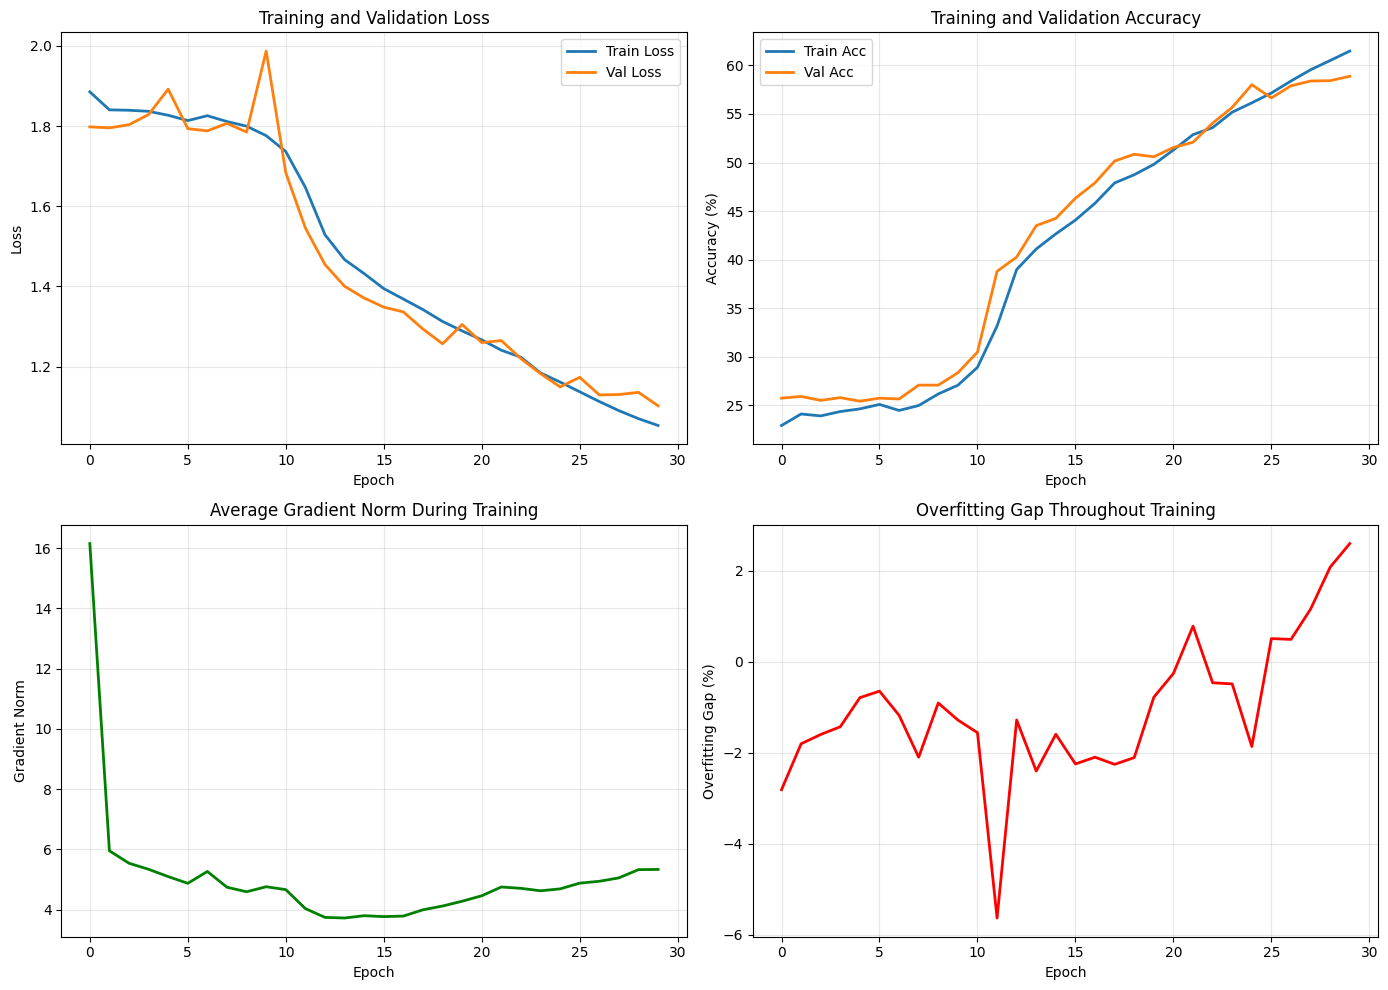

In [17]:
# Plot training history with gradient norms
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gradient norm plot
ax3.plot(grad_norms, 'g-', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Gradient Norm')
ax3.set_title('Average Gradient Norm During Training')
ax3.grid(True, alpha=0.3)

# Overfitting gap plot
overfitting_gaps = [train_accs[i] - val_accs[i] for i in range(len(train_accs))]
ax4.plot(overfitting_gaps, 'r-', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Overfitting Gap (%)')
ax4.set_title('Overfitting Gap Throughout Training')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

Validation: 100%|██████████| 180/180 [00:05<00:00, 32.06it/s, loss=1.42, acc=58.9]


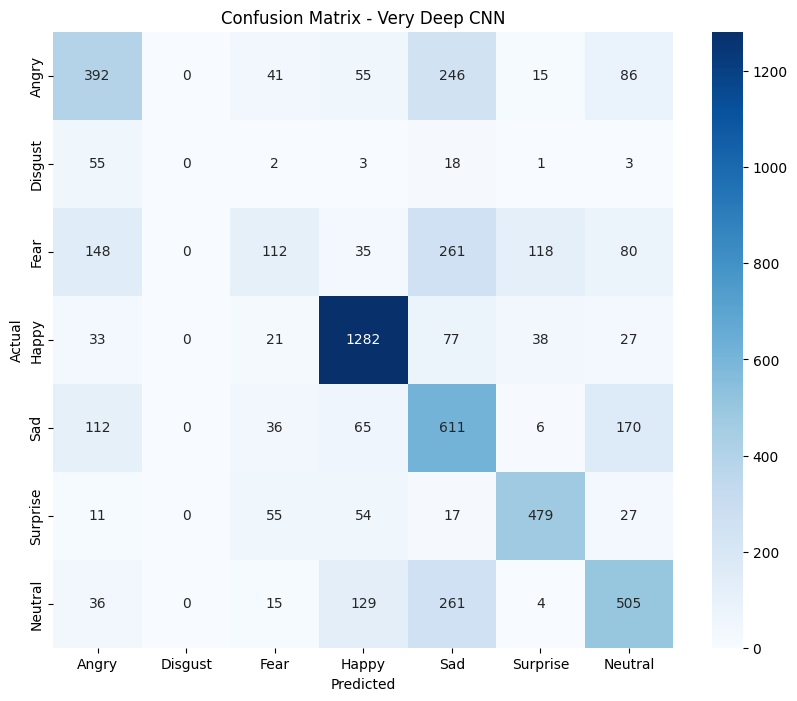

In [18]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_very_deep_cnn_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Confusion matrix
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Very Deep CNN')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

In [19]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))

# Log per-class metrics to W&B
for emotion in emotion_labels:
    wandb.log({
        f"{emotion}_precision": report[emotion]['precision'],
        f"{emotion}_recall": report[emotion]['recall'],
        f"{emotion}_f1": report[emotion]['f1-score']
    })


Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.47      0.48       835
     Disgust       0.00      0.00      0.00        82
        Fear       0.40      0.15      0.22       754
       Happy       0.79      0.87      0.83      1478
         Sad       0.41      0.61      0.49      1000
    Surprise       0.72      0.74      0.73       643
     Neutral       0.56      0.53      0.55       950

    accuracy                           0.59      5742
   macro avg       0.48      0.48      0.47      5742
weighted avg       0.57      0.59      0.57      5742



In [20]:
# Analyze training dynamics for deep networks
print(f"\nTraining Dynamics Analysis:")
print(f"  - Initial Gradient Norm: {grad_norms[0]:.4f}")
print(f"  - Final Gradient Norm: {grad_norms[-1]:.4f}")
print(f"  - Max Gradient Norm: {max(grad_norms):.4f}")
print(f"  - Min Gradient Norm: {min(grad_norms):.4f}")
print(f"  - Average Gradient Norm: {np.mean(grad_norms):.4f}")

misclassified_indices = np.where(np.array(final_predictions) != np.array(final_labels))[0]
print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(final_labels)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(final_labels)*100:.2f}%")


Training Dynamics Analysis:
  - Initial Gradient Norm: 16.1481
  - Final Gradient Norm: 5.3378
  - Max Gradient Norm: 16.1481
  - Min Gradient Norm: 3.7267
  - Average Gradient Norm: 5.0368

Total misclassifications: 2361 out of 5742
Misclassification rate: 41.12%


In [21]:
# Save final model and log to W&B
torch.save(model.state_dict(), 'final_very_deep_cnn_model.pth')
wandb.save('final_very_deep_cnn_model.pth')
wandb.save('best_very_deep_cnn_model.pth')

# Summary statistics
summary_stats = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": best_val_acc,
    "overfitting_gap": train_accs[-1] - val_accs[-1],
    "max_overfitting_gap": max(overfitting_gaps),
    "total_parameters": model.total_params,
    "macro_f1_score": report['macro avg']['f1-score'],
    "weighted_f1_score": report['weighted avg']['f1-score'],
    "avg_gradient_norm": np.mean(grad_norms),
    "training_epochs": len(train_losses)
}

wandb.log(summary_stats)

In [23]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY: VERY DEEP CNN")
print("=" * 70)
print(f"\nModel Architecture:")
print(f"  - 6 Convolutional Blocks (VGG-19 style)")
print(f"  - Total Conv Layers: 18")
print(f"  - Conv channels: [64, 128, 256, 512, 512, 512]")
print(f"  - FC layers: [4096, 2048, 1024, 7]")
print(f"  - Total Parameters: {model.total_params:,}")
print(f"  - Gradient Clipping: max_norm=1.0")
print(f"  - Learning Rate Scheduling: ReduceLROnPlateau")

print(f"\nPerformance Metrics:")
print(f"  - Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Final Overfitting Gap: {train_accs[-1] - val_accs[-1]:.2f}%")
print(f"  - Maximum Overfitting Gap: {max(overfitting_gaps):.2f}%")
print(f"  - Macro F1-Score: {report['macro avg']['f1-score']:.3f}")
print(f"  - Training Epochs: {len(train_losses)}")
print(f"  - Average Gradient Norm: {np.mean(grad_norms):.4f}")

wandb.finish()


EXPERIMENT SUMMARY: VERY DEEP CNN

Model Architecture:
  - 6 Convolutional Blocks (VGG-19 style)
  - Total Conv Layers: 18
  - Conv channels: [64, 128, 256, 512, 512, 512]
  - FC layers: [4096, 2048, 1024, 7]
  - Total Parameters: 37,367,495
  - Gradient Clipping: max_norm=1.0
  - Learning Rate Scheduling: ReduceLROnPlateau

Performance Metrics:
  - Final Training Accuracy: 61.48%
  - Final Validation Accuracy: 58.88%
  - Best Validation Accuracy: 58.88%
  - Final Overfitting Gap: 2.60%
  - Maximum Overfitting Gap: 2.60%
  - Macro F1-Score: 0.471
  - Training Epochs: 30
  - Average Gradient Norm: 5.0368


Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
